<h1><center> Analysis Report for Netflix </center></h1>

__Diclaimer__: This report compiles the analysis done during the _Hackathon_, the final project from the Level 4 Data Analysis bootcamp provided by Cambridge Spark in December 2023.

**Warning**: Running the notebook will take long time due to the _Data cleaning_ process. To help with streamlining the data visualisation process, a static .csv was generated after cleaning the initial dataframe.

## 1. Project introduction

### 1.1 Project overview

Netflix is one of the world's largest streaming platforms, with millions of users streaming movies and TV
shows every day. As a result, Netflix has accumulated a massive amount of data that can be used to gain
insights into user behaviour, preferences, and more.

The CEO of CS-Streaming has brought you and your team in to analyse Netflix data for their new
streaming service. They are confident that your analysis will be helpful to you in making decisions about
their service. They need your expertise to uncover trends and insights from the Netflix data that will be
beneficial to their new product. They are eager to begin this project and will therefore need a timely
response.

__Goal__: You are to report on how CS-Streaming can best optimise its services and compete with Netflix.

### 1.2 Data sourcing

The dataset used was downloaded from _Kaggle_ on 2023-12-12 around 18:30:00 following the [Kaggle's link](https://www.kaggle.com/datasets/shivamb/netflix-shows). The dataset was saved as a csv file entitled "netflix_titles.csv".

The dataset contains the following features:
 - **show_id**: Unique ID for every Movie / Tv Show
 - **type**: Identifier - A Movie or TV Show
 - **title**: Title of the Movie / Tv Show
 - **director**: Director of the Movie
 - **cast**: Actors involved in the movie / show
 - **country**: Country where the movie / show was produced
 - **date_added**: Date it was added on Netflix
 - **release_year**: Actual Release year of the move / show
 - **rating**: TV Rating of the movie / show
 - **duration**: Total Duration - in minutes or number of seasons
 - **liste_in**: Categories of the show (eg Documentary, Drama...)
 - **description**: A short introduction to the show

## 2. Data Preparation

### 2.1 Librairies import

In [1]:
# The following libraires were used throughout the notebook

# import pandas for dataframe manipulation
import pandas as pd 

# data visualisation librairies
import matplotlib # to check version
import matplotlib.pyplot as plt 
import seaborn as sns
sns.set_theme() # set default visualisation apparence to seaborn instead of matplotlib

# librairies for parsing web
import requests
from bs4 import BeautifulSoup
import re
import unicodedata

# import numpy for NaN manipulation
import numpy as np

# import imdbpy to connect to IMDB REST API
!pip install imdbpy
from imdb import Cinemagoer
from imdb import IMDbDataAccessError

# prevent potential warning message to appear
import warnings
warnings.filterwarnings('ignore')

In [2]:
# the following libraries version were used for this project
from platform import python_version
print(f"Python version: {python_version()}")
print(f"Pandas version: {pd.__version__}")
print(f"Matplotlib version: {matplotlib.__version__}")
print(f"Seaborn version: {sns.__version__}")

Python version: 3.11.5
Pandas version: 2.1.1
Matplotlib version: 3.8.0
Seaborn version: 0.12.2


### 2.2 Functions definition

This section collate all the custom function used throughout this report.

In [3]:
def percentage_missing_values(df,self):
    ''' This function calculates the percentage of missing values in either the full datframe or specific columns'''
    if self == 'all':   # for entire dataframe
        for i in df.columns:
            nan_percentage = df[i].isna().sum() / len(df) * 100
            print(f"{i} null rate: {round(nan_percentage, 1)}%")
    else:
        nan_percentage = df[self].isna().sum() / len(df) * 100
        print(f"{self} null rate: {round(nan_percentage, 1)}%")

In [4]:
def respected_uniqueness(df, self):
    '''This function inspect columns where we expect values to be unique and check for duplicates'''
    if len(df[self].unique()) == len(df):
        print(f"The column {self} only has unique values as expected")
    else:
        print(f"The column {self} does not only have unique values and need to be incpested further")

In [5]:
def clean_overview(df, self):
    '''This function give a brief overview of the specified column to check if the data need more cleaning'''
    percentage_missing_values(df,self)
    print(5*"-----")
    print(f"The data type of the column {self} is : {df[self].dtype}")
    print(5*"-----")
    print(df[self].value_counts())

In [6]:
def list_to_string(self):
    '''This function concatenate words in a list into a single string'''
    # initialize an empty string
    string = ""
    # traverse in the string
    for item in self:
        if string == "":
            string = item
        else:
            string = string +", " + item

    # return string
    return string

In [7]:
# to display progress of code for long run
# code available: https://mikulskibartosz.name/how-to-display-a-progress-bar-in-jupyter-notebook
import time, sys
from IPython.display import clear_output

def update_progress(progress):
    bar_length = 20
    if isinstance(progress, int):
        progress = float(progress)
    if not isinstance(progress, float):
        progress = 0
    if progress < 0:
        progress = 0
    if progress >= 1:
        progress = 1

    block = int(round(bar_length * progress))
    clear_output(wait = True)
    text = "Progress: [{0}] {1:.1f}%".format( "#" * block + "-" * (bar_length - block), progress * 100)
    print(text)

## 3. Exploratory Data Analysis (EDA)

### 3.1 Data loading and inspection

In [8]:
# load csv file in a dataframe using pandas
df = pd.read_csv("netflix_titles.csv")

--------------------------------------------------

In [9]:
# inspect top 5 rows of the new dataframe
df.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,NaN,United States,"September 25, 2021",2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm..."
1,s2,TV Show,Blood & Water,NaN,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t..."
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",NaN,"September 24, 2021",2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...
3,s4,TV Show,Jailbirds New Orleans,NaN,NaN,NaN,"September 24, 2021",2021,TV-MA,1 Season,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down amo..."
4,s5,TV Show,Kota Factory,NaN,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",India,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, Romantic TV Shows, TV ...",In a city of coaching centers known to train I...


In [10]:
# inspect last 5 rows of the new dataframe
df.tail()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
8802,s8803,Movie,Zodiac,David Fincher,"Mark Ruffalo, Jake Gyllenhaal, Robert Downey J...",United States,"November 20, 2019",2007,R,158 min,"Cult Movies, Dramas, Thrillers","A political cartoonist, a crime reporter and a..."
8803,s8804,TV Show,Zombie Dumb,NaN,NaN,NaN,"July 1, 2019",2018,TV-Y7,2 Seasons,"Kids' TV, Korean TV Shows, TV Comedies","While living alone in a spooky town, a young g..."
8804,s8805,Movie,Zombieland,Ruben Fleischer,"Jesse Eisenberg, Woody Harrelson, Emma Stone, ...",United States,"November 1, 2019",2009,R,88 min,"Comedies, Horror Movies",Looking to survive in a world taken over by zo...
8805,s8806,Movie,Zoom,Peter Hewitt,"Tim Allen, Courteney Cox, Chevy Chase, Kate Ma...",United States,"January 11, 2020",2006,PG,88 min,"Children & Family Movies, Comedies","Dragged from civilian life, a former superhero..."
8806,s8807,Movie,Zubaan,Mozez Singh,"Vicky Kaushal, Sarah-Jane Dias, Raaghav Chanan...",India,"March 2, 2019",2015,TV-14,111 min,"Dramas, International Movies, Music & Musicals",A scrappy but poor boy worms his way into a ty...


--------------------------------------------------

In [11]:
# inspect number of features and shows
print(f"There are {df.shape[0]} shows in the database\nThere are {df.shape[1]} features in the database")

There are 8807 shows in the database
There are 12 features in the database


In [12]:
# inspect the columns name
print(df.columns)

Index(['show_id', 'type', 'title', 'director', 'cast', 'country', 'date_added',
       'release_year', 'rating', 'duration', 'listed_in', 'description'],
      dtype='object')


--------------------------------------------------

In [13]:
# inspect data types of columns
df.dtypes

show_id         object
type            object
title           object
director        object
cast            object
country         object
date_added      object
release_year     int64
rating          object
duration        object
listed_in       object
description     object
dtype: object

Most of the columns are classified as _objects_ whereas they would be expected to be _strings_. This will need to be addressed in the _Data cleaning_ section.

--------------------------------------------------

In [14]:
# inspect missing data
df.isna().sum()

show_id            0
type               0
title              0
director        2634
cast             825
country          831
date_added        10
release_year       0
rating             4
duration           3
listed_in          0
description        0
dtype: int64

The columns *show_id, type, title, release_year, listed_in,* and *description* do not appear to have missing values.

The others have a significant numbers of _NaN_ values and will need to be addressed in the _Data Cleaning_ section.

In [15]:
# inspect proportions of missing data in database
percentage_missing_values(df, 'all')

show_id null rate: 0.0%
type null rate: 0.0%
title null rate: 0.0%
director null rate: 29.9%
cast null rate: 9.4%
country null rate: 9.4%
date_added null rate: 0.1%
release_year null rate: 0.0%
rating null rate: 0.0%
duration null rate: 0.0%
listed_in null rate: 0.0%
description null rate: 0.0%


--------------------------------------------------

There is only one column with numerical data on which we can run a statistical analysis:

In [16]:
df.describe()

,release_year
count,8807.000000
mean,2014.180198
std,8.819312
min,1925.000000
25%,2013.000000
50%,2017.000000
75%,2019.000000
max,2021.000000


From the results above, we can see that the data span from 1925 to 2021. This range will need to be assessed for accuracy in the _Data Cleaning_ section.

--------------------------------------------------

In [17]:
# ensure that show_id has truly unique values
respected_uniqueness(df, 'show_id')

# ensure that title has truly unique values
respected_uniqueness(df, 'title')

The column show_id only has unique values as expected
The column title only has unique values as expected


The columns *show_id* and *title* appear to be clean, as they do not have missing values and do not have duplicates.

--------------------------------------------------

**Summary and next steps**: \
From our EDA, we identified a few actions needed in _Data cleaning_ before proceeding the analysis of the data.
- There are a lot of missing data (>5%) in the columns *director*, *cast*, and *country*
- There are a small number of missing data (<1%) in the columns *date_added*, *rating*, and *duration*
- All those object are categorical data or date. We cannot replace the missing data with mean values for example.
- The data types of most of the features are _objects_ and will need to be changed to more accurate ones
- Data seems to span from 1925 to 2021 and range should be inspected for reliability
- The columns *show_id* and *title* appear to be clean

### 3.2 Data cleaning

### 3.2.1 Column *type*

In [18]:
# assign data type to string
df['type'] = df['type'].astype('string')

In [19]:
clean_overview(df, 'type')

type null rate: 0.0%
-------------------------
The data type of the column type is : string
-------------------------
type
Movie      6131
TV Show    2676
Name: count, dtype: Int64


**Conclusion**: The column _type_ has no missing values, strings values, and has two unique values as expected. The column looks clean.

### 3.2.2 Column _director_

The column _director_ is the column with the most of missing data. This will be addressed first as much as possible.

The first step will identify the relevant pages for shows with missing director data, if they exist, and collect the info.

In [20]:
%%time
for i in range(0, len(df)):
    if df.loc[i, 'director'] is np.nan:
        title = df.loc[i, 'title'].replace(r" ", "_")
        try:
            url = "https://en.wikipedia.org/wiki/" + title
            response = requests.get(url)
            soup = BeautifulSoup(response.text, 'html.parser')
            #print(soup.title)
        except:
            continue
        # directors
        try:
            director = soup.find("td", {"class": "infobox-data attendee"}).string
            df.loc[i, 'director']=director
        except: continue
        
    time.sleep(0.1)
    update_progress(i / len(df))

update_progress(1)

Progress: [####################] 100.0%
CPU times: total: 10min 35s
Wall time: 37min 28s


In [21]:
df.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,NaN,United States,"September 25, 2021",2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm..."
1,s2,TV Show,Blood & Water,NaN,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t..."
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",NaN,"September 24, 2021",2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...
3,s4,TV Show,Jailbirds New Orleans,NaN,NaN,NaN,"September 24, 2021",2021,TV-MA,1 Season,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down amo..."
4,s5,TV Show,Kota Factory,Raghav Subbu,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",India,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, Romantic TV Shows, TV ...",In a city of coaching centers known to train I...


In [22]:
df.isna().sum()

show_id            0
type               0
title              0
director        2298
cast             825
country          831
date_added        10
release_year       0
rating             4
duration           3
listed_in          0
description        0
dtype: int64

The process takes time. A static csv file was generated to streamline the rest of the process.

There were still a lot of missing data left and a new approach was implemented by parsing the website [IMDb](https://www.imdb.com/)

In [23]:
# create instance
ia = Cinemagoer(accessSystem='http', reraiseExceptions=True)

In [24]:
%%time
for i in range(0, len(df)):
    if df.loc[i, 'director'] is np.nan:
        show_title = df.loc[i, 'title']
        try:
            search_movie = ia.search_movie(show_title)
        except:
            continue
        try:
            id_ = search_movie[0].getID()
        except:
            continue
        try:
            movie = ia.get_movie(id_)
        except:
            continue
        
        # director mising data
        if df.loc[i, 'director'] is np.nan:
            try:
                director=movie['director'][0]['name']
            except:
                director=np.nan
            df.loc[i, 'director'] = director

    time.sleep(0.1)
    update_progress(i / len(df))

update_progress(1)

Progress: [####################] 100.0%
CPU times: total: 44.9 s
Wall time: 2h 16min 6s


In [25]:
# general inspection
clean_overview(df, 'director')

director null rate: 21.4%
-------------------------
The data type of the column director is : object
-------------------------
director
Rajiv Chilaka                         21
Raúl Campos, Jan Suter                18
Suhas Kadav                           17
Marcus Raboy                          16
Jay Karas                             14
                                      ..
Josh Aronson                           1
Luke Snellin                           1
Xavier Durringer                       1
Javier Fuentes-León, Carlos Moreno     1
Mozez Singh                            1
Name: count, Length: 5082, dtype: int64


### 3.2.3 Column _cast_

In [26]:
%%time
for i in range(0, len(df)):
    # cast missing data
    if (df.loc[i, 'cast'] is np.nan) or (df.loc[i, 'director'] is np.nan):
        show_title = df.loc[i, 'title']
        try:
            search_movie = ia.search_movie(show_title)
        except:
            continue
        try:
            id_ = search_movie[0].getID()
        except:
            continue
        try:
            movie = ia.get_movie(id_)
        except:
            continue
            
        # missing data in cast
        if (df.loc[i, 'cast'] is np.nan):
            actor_list=[]
            try:
                movie = ia.get_movie(id_)
                for actor in movie['cast']:
                    actor_list.append(actor['name'])
            except:
                actor_list=[np.nan]
            df.at[i, 'cast']=list_to_string(actor_list)
            
    time.sleep(0.1)
    update_progress(i / len(df))

update_progress(1)

Progress: [####################] 100.0%
CPU times: total: 1min 23s
Wall time: 3h 6min 36s


In [27]:
# general inspection
clean_overview(df, 'cast')

cast null rate: 1.5%
-------------------------
The data type of the column cast is : object
-------------------------
cast
David Attenborough                                                                                                                                                                           19
Vatsal Dubey, Julie Tejwani, Rupa Bhimani, Jigna Bhardwaj, Rajesh Kava, Mousam, Swapnil                                                                                                      14
Samuel West                                                                                                                                                                                  10
Jeff Dunham                                                                                                                                                                                   7
David Spade, London Hughes, Fortune Feimster                                                                 

### 3.2.4 Column _country_

In [28]:
%%time
for i in range(0, len(df)):
    if df.loc[i, 'country'] is np.nan:
        title = df.loc[i, 'title'].replace(r" ", "_")
        try:
            url = "https://en.wikipedia.org/wiki/" + title
            response = requests.get(url)
            soup = BeautifulSoup(response.text, 'html.parser')
        except:
            continue
        # country
        try:
            table = soup.find('table', {"class": "infobox vevent"})
            country = str(table).partition('Country of origin</th><td class="infobox-data"')[2]
            country = country.partition('<')[0]
            country= country[1:]
            if country != "":
                df.loc[i, 'country']=country
            else:
                df.loc[i, 'country']=np.nan
        except: continue

    time.sleep(0.1)
    update_progress(i / len(df))

update_progress(1)

Progress: [####################] 100.0%
CPU times: total: 2min 57s
Wall time: 22min 32s


In [29]:
# general inspection
clean_overview(df, 'country')

country null rate: 8.2%
-------------------------
The data type of the column country is : object
-------------------------
country
United States                             2862
India                                      993
United Kingdom                             421
Japan                                      248
South Korea                                214
                                          ... 
Romania, Bulgaria, Hungary                   1
Uruguay, Guatemala                           1
France, Senegal, Belgium                     1
Mexico, United States, Spain, Colombia       1
United Arab Emirates, Jordan                 1
Name: count, Length: 750, dtype: int64


### 3.2.5 Column _date_added_

In [30]:
# inspect missing rows with missing values
df_missing_date = df[df['date_added'].isna()]
df_missing_date

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
6066,s6067,TV Show,A Young Doctor's Notebook and Other Stories,None,"Daniel Radcliffe, Jon Hamm, Adam Godley, Chris...",United Kingdom,NaN,2013,TV-MA,2 Seasons,"British TV Shows, TV Comedies, TV Dramas","Set during the Russian Revolution, this comic ..."
6174,s6175,TV Show,Anthony Bourdain: Parts Unknown,Anthony Bourdain,Anthony Bourdain,United States,NaN,2018,TV-PG,5 Seasons,Docuseries,This CNN original series has chef Anthony Bour...
6795,s6796,TV Show,Frasier,None,"Kelsey Grammer, Jane Leeves, David Hyde Pierce...",United States,NaN,2003,TV-PG,11 Seasons,"Classic & Cult TV, TV Comedies",Frasier Crane is a snooty but lovable Seattle ...
6806,s6807,TV Show,Friends,None,"Jennifer Aniston, Courteney Cox, Lisa Kudrow, ...",United States,NaN,2003,TV-14,10 Seasons,"Classic & Cult TV, TV Comedies",This hit sitcom follows the merry misadventure...
6901,s6902,TV Show,Gunslinger Girl,NaN,"Yuuka Nanri, Kanako Mitsuhashi, Eri Sendai, Am...",Japan,NaN,2008,TV-14,2 Seasons,"Anime Series, Crime TV Shows","On the surface, the Social Welfare Agency appe..."
7196,s7197,TV Show,Kikoriki,None,Igor Dmitriev,Russia,NaN,2010,TV-Y,2 Seasons,Kids' TV,A wacky rabbit and his gang of animal pals hav...
7254,s7255,TV Show,La Familia P. Luche,NaN,"Eugenio Derbez, Consuelo Duval, Luis Manuel Áv...",United States,NaN,2012,TV-14,3 Seasons,"International TV Shows, Spanish-Language TV Sh...","This irreverent sitcom featues Ludovico, Feder..."
7406,s7407,TV Show,Maron,NaN,"Marc Maron, Judd Hirsch, Josh Brener, Nora Zeh...",United States,NaN,2016,TV-MA,4 Seasons,TV Comedies,"Marc Maron stars as Marc Maron, who interviews..."
7847,s7848,TV Show,Red vs. Blue,None,"Burnie Burns, Jason Saldaña, Gustavo Sorola, G...",United States,NaN,2015,NR,13 Seasons,"TV Action & Adventure, TV Comedies, TV Sci-Fi ...","This parody of first-person shooter games, mil..."
8182,s8183,TV Show,The Adventures of Figaro Pho,NaN,"Luke Jurevicius, Craig Behenna, Charlotte Haml...",Australia,NaN,2015,TV-Y7,2 Seasons,"Kids' TV, TV Comedies","Imagine your worst fears, then multiply them: ..."


In [31]:
# convert date_added to date format
df['date_added'] = df['date_added'].apply(pd.to_datetime).dt.date
df['date_added'].dtypes

dtype('O')

In [32]:
df.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,"Michael Hilow, Ana Hoffman, Dick Johnson, Kirs...",United States,2021-09-25,2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm..."
1,s2,TV Show,Blood & Water,NaN,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,2021-09-24,2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t..."
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",France,2021-09-24,2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...
3,s4,TV Show,Jailbirds New Orleans,NaN,NaN,NaN,2021-09-24,2021,TV-MA,1 Season,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down amo..."
4,s5,TV Show,Kota Factory,Raghav Subbu,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",India,2021-09-24,2021,TV-MA,2 Seasons,"International TV Shows, Romantic TV Shows, TV ...",In a city of coaching centers known to train I...


The column looks clean with the adequate format. To simply future analysis, the month will also be extracted.

In [33]:
# extract the month from date_added into a new column
for i in range (0, len(df)):
    if df.loc[i, 'date_added'] is not np.nan:
        df.loc[i, 'release_month'] = df.loc[i, 'date_added'].month
    else:
        df.loc[i, 'release_month'] = np.nan
    
# move column next to year
column_to_move = df.pop('release_month')
df.insert(9, 'release_month', column_to_move)

# visualise updated dataframe
df.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,release_month,duration,listed_in,description
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,"Michael Hilow, Ana Hoffman, Dick Johnson, Kirs...",United States,2021-09-25,2020,PG-13,9.0,90 min,Documentaries,"As her father nears the end of his life, filmm..."
1,s2,TV Show,Blood & Water,NaN,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,2021-09-24,2021,TV-MA,9.0,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t..."
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",France,2021-09-24,2021,TV-MA,9.0,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...
3,s4,TV Show,Jailbirds New Orleans,NaN,NaN,NaN,2021-09-24,2021,TV-MA,9.0,1 Season,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down amo..."
4,s5,TV Show,Kota Factory,Raghav Subbu,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",India,2021-09-24,2021,TV-MA,9.0,2 Seasons,"International TV Shows, Romantic TV Shows, TV ...",In a city of coaching centers known to train I...


In [34]:
# general inspection
clean_overview(df, 'date_added')
print(5*"#####")
clean_overview(df, 'release_month')

date_added null rate: 0.1%
-------------------------
The data type of the column date_added is : object
-------------------------
date_added
2020-01-01    110
2019-11-01     91
2018-03-01     75
2019-12-31     74
2018-10-01     71
             ... 
2017-02-21      1
2017-02-07      1
2017-01-29      1
2017-01-25      1
2020-01-11      1
Name: count, Length: 1714, dtype: int64
#########################
release_month null rate: 0.1%
-------------------------
The data type of the column release_month is : float64
-------------------------
release_month
7.0     827
12.0    813
9.0     770
4.0     764
10.0    760
8.0     755
3.0     742
1.0     738
6.0     728
11.0    705
5.0     632
2.0     563
Name: count, dtype: int64


### 3.2.6 Column _release_year_

From the initial overview, we know that the year go from 1925 to 2021. We will start by looking at the detail of each year.

In [35]:
# check release_year
year_set = set(df.release_year.unique())
print(year_set)

{1925, 1942, 1943, 1944, 1945, 1946, 1947, 1954, 1955, 1956, 1958, 1959, 1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021}


The year 1925 looks indeed odd and out of place and need further investigation.

In [36]:
df.loc[df['release_year']==1925]

,show_id,type,title,director,cast,country,date_added,release_year,rating,release_month,duration,listed_in,description
4250,s4251,TV Show,Pioneers: First Women Filmmakers*,NaN,NaN,NaN,2018-12-30,1925,TV-14,12.0,1 Season,TV Shows,This collection restores films from women who ...


According to the _date_added_ column, the value should be 2018 instead of 2021. It is very likely a typo and we changed it accordingly.

In [37]:
# change year to the right value
df.loc[4250,'release_year'] = 2018

In [38]:
# check release_year again
year_set = set(df.release_year.unique())
print(year_set)

{1942, 1943, 1944, 1945, 1946, 1947, 1954, 1955, 1956, 1958, 1959, 1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021}


In [39]:
# general inspection
clean_overview(df, 'release_year')

release_year null rate: 0.0%
-------------------------
The data type of the column release_year is : int64
-------------------------
release_year
2018    1148
2017    1032
2019    1030
2020     953
2016     902
        ... 
1964       2
1966       1
1959       1
1947       1
1961       1
Name: count, Length: 73, dtype: int64


### 3.2.7 Column _rating_

In [40]:
# inspect values in rating
df.rating.value_counts()

rating
TV-MA       3207
TV-14       2160
TV-PG        863
R            799
PG-13        490
TV-Y7        334
TV-Y         307
PG           287
TV-G         220
NR            80
G             41
TV-Y7-FV       6
NC-17          3
UR             3
74 min         1
84 min         1
66 min         1
Name: count, dtype: int64

From the values above, three seemed misplaced. The values: 74 min, 84 min, and 66 min actually belong to the colum _duration_.

In [41]:
df.loc[df['rating']=="74 min"]

,show_id,type,title,director,cast,country,date_added,release_year,rating,release_month,duration,listed_in,description
5541,s5542,Movie,Louis C.K. 2017,Louis C.K.,Louis C.K.,United States,2017-04-04,2017,74 min,4.0,NaN,Movies,"Louis C.K. muses on religion, eternal love, gi..."


In [42]:
df.loc[df['rating']=="84 min"]

,show_id,type,title,director,cast,country,date_added,release_year,rating,release_month,duration,listed_in,description
5794,s5795,Movie,Louis C.K.: Hilarious,Louis C.K.,Louis C.K.,United States,2016-09-16,2010,84 min,9.0,NaN,Movies,Emmy-winning comedy writer Louis C.K. brings h...


In [43]:
df.loc[df['rating']=="66 min"]

,show_id,type,title,director,cast,country,date_added,release_year,rating,release_month,duration,listed_in,description
5813,s5814,Movie,Louis C.K.: Live at the Comedy Store,Louis C.K.,Louis C.K.,United States,2016-08-15,2015,66 min,8.0,NaN,Movies,The comic puts his trademark hilarious/thought...


In [44]:
# replace values in duration
df.loc[5541, 'rating'] = df.loc[5541, 'release_year']
df.loc[5794, 'rating'] = df.loc[5541, 'release_year']
df.loc[5813, 'rating'] = df.loc[5541, 'release_year']

# a google search on the three titles showed that the rating should be TV-MA in the US
df.loc[5541, 'rating'] = "TV-MA"
df.loc[5794, 'rating'] = "TV-MA"
df.loc[5813, 'rating'] = "TV-MA"

In [45]:
# inspect values in rating again
df.rating.value_counts()

rating
TV-MA       3210
TV-14       2160
TV-PG        863
R            799
PG-13        490
TV-Y7        334
TV-Y         307
PG           287
TV-G         220
NR            80
G             41
TV-Y7-FV       6
NC-17          3
UR             3
Name: count, dtype: int64

In [46]:
# assign data type to string
df['rating'] = df['rating'].astype('string')

The various ratings were fairly confusing, as they were open to interpretation, and were not consistent across regions. Their descriptions can be found on [Netflix help center](https://help.netflix.com/en/node/2064/us).

To simplify our analysis, the ratings were divided in three categories based on Natflix' guidelines: Adult, Teens, and Kids.

In [47]:
# create a dictionary with ratings/suitable audiences
maturity_dictionary = {
    "TV-MA": "Adults",
    "TV-14": "Teens",
    "TV-PG": "Kids",
    "R": "Adults",
    "PG-13": "Teens",
    "TV-Y7": "Kids",
    "TV-Y": "Kids",
    "PG": "Kids",
    "TV-G": "Kids",
    "NR": "No rating",
    "G": "Kids",
    "TV-Y7-FV": "Kids",
    "NC-17": "Adults",
    "UR": "Kids"
}

In [48]:
# generate a new column with uniform ratings
df['audience'] = df['rating'].map(maturity_dictionary)

# move column next to year
column_to_move = df.pop('audience')
df.insert(11, 'audience', column_to_move)

df.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,release_month,duration,audience,listed_in,description
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,"Michael Hilow, Ana Hoffman, Dick Johnson, Kirs...",United States,2021-09-25,2020,PG-13,9.0,90 min,Teens,Documentaries,"As her father nears the end of his life, filmm..."
1,s2,TV Show,Blood & Water,NaN,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,2021-09-24,2021,TV-MA,9.0,2 Seasons,Adults,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t..."
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",France,2021-09-24,2021,TV-MA,9.0,1 Season,Adults,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...
3,s4,TV Show,Jailbirds New Orleans,NaN,NaN,NaN,2021-09-24,2021,TV-MA,9.0,1 Season,Adults,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down amo..."
4,s5,TV Show,Kota Factory,Raghav Subbu,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",India,2021-09-24,2021,TV-MA,9.0,2 Seasons,Adults,"International TV Shows, Romantic TV Shows, TV ...",In a city of coaching centers known to train I...


In [49]:
# general inspection
clean_overview(df, 'rating')

# general inspection
clean_overview(df, 'audience')

rating null rate: 0.0%
-------------------------
The data type of the column rating is : string
-------------------------
rating
TV-MA       3210
TV-14       2160
TV-PG        863
R            799
PG-13        490
TV-Y7        334
TV-Y         307
PG           287
TV-G         220
NR            80
G             41
TV-Y7-FV       6
NC-17          3
UR             3
Name: count, dtype: Int64
audience null rate: 0.0%
-------------------------
The data type of the column audience is : object
-------------------------
audience
Adults       4012
Teens        2650
Kids         2061
No rating      80
Name: count, dtype: int64


### 3.2.8 Column _listed_in_

In [50]:
# assign data type to string
df['listed_in'] = df['listed_in'].astype('string')

In [51]:
# general inspection
clean_overview(df, 'listed_in')

listed_in null rate: 0.0%
-------------------------
The data type of the column listed_in is : string
-------------------------
listed_in
Dramas, International Movies                        362
Documentaries                                       359
Stand-Up Comedy                                     334
Comedies, Dramas, International Movies              274
Dramas, Independent Movies, International Movies    252
                                                   ... 
Classic Movies, Cult Movies, Documentaries            1
Action & Adventure, Cult Movies, Dramas               1
Classic Movies, Dramas, LGBTQ Movies                  1
Children & Family Movies, Classic Movies              1
Cult Movies, Dramas, Thrillers                        1
Name: count, Length: 514, dtype: Int64


### 3.2.8 Column _description_

In [52]:
# assign data type to string
df['description'] = df['description'].astype('string')

In [53]:
# general inspection
clean_overview(df, 'description')

description null rate: 0.0%
-------------------------
The data type of the column description is : string
-------------------------
description
Paranormal activity at a lush, abandoned property alarms a group eager to redevelop the site, but the eerie events may not be as unearthly as they think.    4
A surly septuagenarian gets another chance at her 20s after having her photo snapped at a studio that magically takes 50 years off her life.                 3
Multiple women report their husbands as missing but when it appears they are looking for the same man, a police officer traces their cryptic connection.     3
Challenged to compose 100 songs before he can marry the girl he loves, a tortured but passionate singer-songwriter embarks on a poignant musical journey.    3
A scheming matriarch plots to cut off her disabled stepson and his wife from the family fortune, creating a division within the clan.                        2
                                                             

### 3.2.9 General overview of clean data

In [54]:
# missing values
percentage_missing_values(df, 'all')

show_id null rate: 0.0%
type null rate: 0.0%
title null rate: 0.0%
director null rate: 21.4%
cast null rate: 1.5%
country null rate: 8.2%
date_added null rate: 0.1%
release_year null rate: 0.0%
rating null rate: 0.0%
release_month null rate: 0.1%
duration null rate: 0.0%
audience null rate: 0.0%
listed_in null rate: 0.0%
description null rate: 0.0%


The amount a missing data has decreased compared to 

NameError: name 'df_original' is not defined

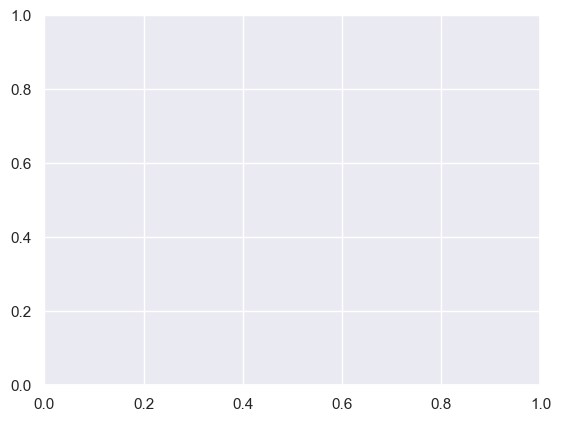

In [59]:
# plot cleaning results
fig, ax = plt.subplots()
original = ax.bar(df_original.value_counts(), bar_width, label="Raw data")

cleaned = ax.bar(bar_width, df_clean.value_counts(), bar_width, label="Clean data")

ax.set_xlabel('Shows features')
ax.set_ylabel('Number of missing data')
ax.set_title('Comparison between raw database and cleaned databases')
ax.set_xticks(bar_width / 2)
ax.set_xticklabels(["Show ID", "Type", "Title", "Director", "Cast", "Country", "Date added", "Release year", "Rating", "Audience", "Duration", "Listed in", "Description"])
ax.legend()

plt.show()

In [ ]:
# generate a static csv for avoid repeating cleaning steps
df.to_csv('static_csv.csv')

In [ ]:
##4. Data visualisation

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


TypeError: missing a required argument: 'x'

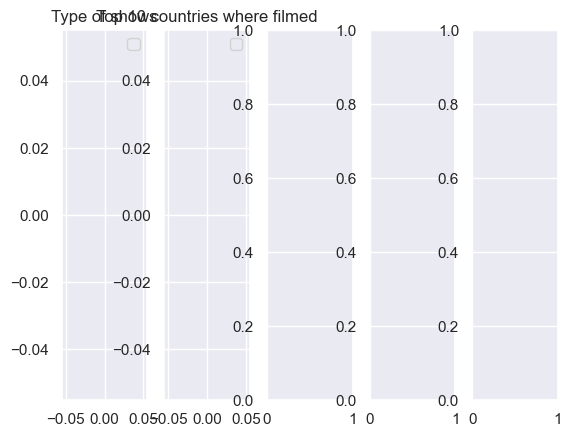

In [58]:
# General overview
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(nrows=1, ncols=5)

ax1.plot(data=df['type'])
ax1.legend()
ax1.set(title='Type of shows')

ax2.plot(data=df['country'].head(10))
ax2.legend()
ax2.set(title='Top 10 countries where filmed')

ax3.hist(data=df['release_year'], bins=20)
ax3.legend()
ax3.set(title='Release through years')

ax4.hist(data=df['release_month'], bins=12)
ax4.legend()
ax4.set(title='Release through months')

ax5.plot(data=df['audience'])
ax5.legend()
ax5.set(title='Youngest audience for ratings')

plt.show()